# Анализ криптовалютного рынка

## Что тут происходит

Финальная цель исследования - уметь делать фундаментальный анализ токенов и инвестировать в них исходя из фундаментальных показателей, а не технических.

Но для начала хочется понять структуру крипторынка: какие токены с какими связаны, какие группы (отрасли?) есть на рынке.

Для этого я беру суточные котировки токенов на binance за последний год и считаю корреляции между всеми парами токенов. Получается матрица корреляций. Я преобразую её в матрицу расстояний и по этой матрице строю дерево связей между токенами: какие меняются синхронно, а какие - нет. (Подробнее см. https://t.me/cloud_white_horses/60). Получаются группы, которые меняются совместно (и значит, нет смысла держать два токена из одной группы, т.к. долгосрочно это не диверсифицирует портфель).

## Задачи

Сложные задачи помечены звёздочкой: (*).

1. [ ] Установите и запустите сервер Jupyter, установите нужные библиотеки, запустите тетрадку. Убедитесь, что все ячейки выполнились. 
2. [ ] Прочитайте тетрадку, разберитесь, что в ней происходит.
3. [ ] Проверьте устойчивость минимального остовного дерева:
   * [ ] По времени: поменяется ли дерево, если считать корреляции не за год, а за полгода или квартал, или за разные кварталы.
   * [ ] По методу расчёта корреляции: я беру ранговую корреляцию Спирмена, а что если взять стандартную корреляцию Пирсона?
   * [ ] По набору токенов: поменяется ли дерево, если считать корреляции по первым 20 токенам или, наоборот, по всем? (Тут придётся написать скачиватель с coinmarketcap или ещё откуда-то)
4. [ ] Посчитайте корреляции со сдвигом во времени: 1 день, 3 дня, 7 дней и т.д. Постройте остовныые деревья по сдвинутым корреляциям. Сравните их между собой.
   * Заметьте, что матрицы перестанут быть симметричными: в ячейке `[i, j]` будет корреляция токена `i` с прошлыми значениями токена `j`, а в ячейке `[j, i]` -- уже корреляция токена `j` с прошлыми значениями токена `i`. Соответственно, граф из ненаправленного станет направленным. Нужно модифицировть код, чтобы это учесть.
5. [ ] (*) Кроме минимального остовного дерева, я пробую просто взять граф расстояний и выкинуть из него длинные рёбра (т.е. рёбра с низкой корреляцией). Но получается плохо: остаётся много изолированных вершин и крупные переплетённые кластеры, в которых не видно структуры. Что если строить граф хитрее: выбрасывать рёрба начиная с самого длинного, но не допускать, чтобы узел остался совсем без рёбер?
   * Тут надо придумать метрику качества "прополки графа", написать свой алгоритм удаления рёбер и потестировать его против этой метрики. Может оказаться, что лучше остовного дерева ничего нет.

## Данные

Данные я выкачал вручную с coinmarketcap.com: (1) нажимаем на токен, переходим на страницу с графиком котировок; (2) в правом верхнем углу графика выбираем 1Y (на графике отобразятся данные за последний год), (3) там же в правом верхнем углу нажимаем кнопку "Скачать", сохраняем .csv-файл в папку Data.

Я выкачал около 70 токенов с наибольшей капитализацией. В репозитории лежат данные за начало июня 2023.

## Материалы

* Курс-ликбез по криптовалюте: https://www.coursera.org/specializations/decentralized-finance-duke
* Пост, где объясняю идею того, что тут делаю: https://t.me/cloud_white_horses/60
* (*) Книга, откуда я это взял: Frantisek Slanina. Essentials of Econophysics Modelling (https://www.amazon.com/Essentials-Econophysics-Modelling-Frantisek-Slanina/dp/0199299684))
* Википедия (русская или английская) для незнакомых терминов из математики. Например, про разные виды корреляции или остовные деревья.
* Официальная документация по [pandas](https://pandas.pydata.org/docs/user_guide/index.html#user-guide), [scipy](https://docs.scipy.org/doc/scipy/tutorial/index.html#user-guide), [igraph](https://python.igraph.org/en/stable/).

## Идеи на будущее

* [ ] Что будет с корреляциями, если сначала убрать из графиков тренд?
* [ ] На графиках котировок, если смотреть долгосрочно, не видно одного тренда: тренды сменяют друг друга, так что получается кусочно-линейный график. Хочется, видя текущий тренд токена, понимать, сколько он ещё продлится, скоро ли переменится, и куда будет направлен новый тренд.
  * [ ] Сколько в среднем длится один тренд? Как выглядит распределение длительностей трендов для разных токенов? Зависит ли оно от токена?
  * [ ] Зависит ли длительность тренда от его направления и крутизны?
  * [ ] Есть ли зависимость между направлением предыдущего тренда и нынешнего? Может быть, за положительным трендом чаще следует плато, а не падение?
* [ ] Корреляции со сдвигом во времени - очень грубый способ поиска причинности. Гипотеза: можно сделать лучше с помощью [причинности Грейнджера](https://en.wikipedia.org/wiki/Granger_causality).
* [ ] Что, если применить [модель CAPM](https://en.wikipedia.org/wiki/Capital_asset_pricing_model), взяв вместо индекса -- биткоин или эфир?

# Inits

In [1]:
%matplotlib inline

from glob import glob
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.linalg import eig
import igraph
import prophet
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.serialize import model_to_json
from IPython.display import display, HTML

/home/krvkir/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load data

Загрузим данные по каждому токену, минимально обработаем их, сольём в одну таблицу.

In [2]:
path_mask = '../data/*_1Y_graph_coinmarketcap.csv'

In [3]:
def process(df: pd.DataFrame):
    """ Calculate additional values, convert dates etc. """
    # Calculate centered and normalized values for time series.
    df['value'] = (df['close'] - df['close'].mean()) / df['close'].std()
    # Parse datetime values.
    df['dttm'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%dT%H:%M:%S.000Z')


accum = []

for filename in glob(path_mask):
    token = filename.split('/')[-1].split('_')[0]
    print(token, filename)
    df = pd.read_csv(filename, sep=';').assign(token=token)
    process(df)
    accum.append(df)

ticks = pd.concat(accum)

DOGE ../data/DOGE_1Y_graph_coinmarketcap.csv
ETH ../data/ETH_1Y_graph_coinmarketcap.csv
ADA ../data/ADA_1Y_graph_coinmarketcap.csv
LTC ../data/LTC_1Y_graph_coinmarketcap.csv
CFX ../data/CFX_1Y_graph_coinmarketcap.csv
CRV ../data/CRV_1Y_graph_coinmarketcap.csv
ALGO ../data/ALGO_1Y_graph_coinmarketcap.csv
THETA ../data/THETA_1Y_graph_coinmarketcap.csv
TON ../data/TON_1Y_graph_coinmarketcap.csv
QNT ../data/QNT_1Y_graph_coinmarketcap.csv
XLM ../data/XLM_1Y_graph_coinmarketcap.csv
IMX ../data/IMX_1Y_graph_coinmarketcap.csv
NEAR ../data/NEAR_1Y_graph_coinmarketcap.csv
EGLD ../data/EGLD_1Y_graph_coinmarketcap.csv
CRO ../data/CRO_1Y_graph_coinmarketcap.csv
MANA ../data/MANA_1Y_graph_coinmarketcap.csv
MATIC ../data/MATIC_1Y_graph_coinmarketcap.csv
AVAX ../data/AVAX_1Y_graph_coinmarketcap.csv
UNI ../data/UNI_1Y_graph_coinmarketcap.csv
BNB ../data/BNB_1Y_graph_coinmarketcap.csv
VET ../data/VET_1Y_graph_coinmarketcap.csv
SOL ../data/SOL_1Y_graph_coinmarketcap.csv
LINK ../data/LINK_1Y_graph_coinmar

In [4]:
ticks.token.value_counts()

token
DOGE    364
ETH     364
BTC     364
AXS     364
KCS     364
       ... 
INJ     364
LINK    360
APT     245
ARB      90
PEPE     65
Name: count, Length: 67, dtype: int64

Посмотрим на графики котировок.

In [5]:
def plot_ticks(ticks: pd.DataFrame, tokens: list, metric: str = 'value'):
    """ Plot given ticks in one frame. """
    return ticks[ticks.token.isin(tokens)].groupby('token')[metric].plot(
        legend=True
    )

token
BTC    Axes(0.125,0.11;0.775x0.77)
ETH    Axes(0.125,0.11;0.775x0.77)
Name: value, dtype: object

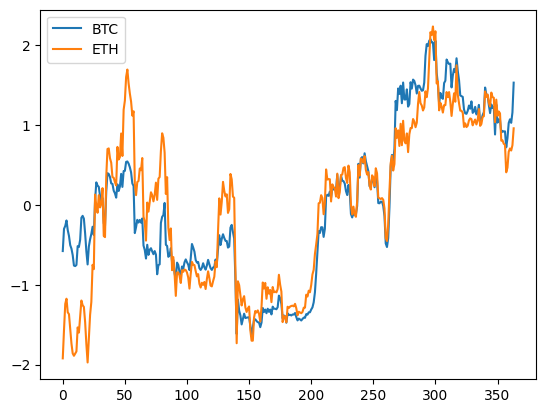

In [6]:
plot_ticks(ticks, ['BTC', 'ETH'])

### Market cap

Построим текущую капитализацию токенов (пригодится для визуализации графа и дерева ниже).

In [7]:
market_caps = (
    ticks[ticks.dttm == ticks.dttm.max()]
    .set_index('token')
    ['marketCap']
    .sort_index()
)

## Volumes

Посмотрим на объёмы торгов.

In [8]:
ticks.head(3)

open      high       low     close        volume     marketCap  \
0  0.065606  0.065751  0.061389  0.061711  6.336193e+08  8.187306e+09   
1  0.061703  0.064615  0.061703  0.064032  4.341698e+08  8.495222e+09   
2  0.064019  0.068162  0.064004  0.067124  5.147294e+08  8.905403e+09   

                  timestamp token     value       dttm  
0  2022-06-22T00:00:00.000Z  DOGE -1.064742 2022-06-22  
1  2022-06-23T00:00:00.000Z  DOGE -0.891998 2022-06-23  
2  2022-06-24T00:00:00.000Z  DOGE -0.661882 2022-06-24

There's only trading volumes! I need transaction volumes on the net, but that's not easy:

* there are complex transactions (smart contracts execution)
* tokens are not uniform: some are mainnet tokens, some are ERC20 tokens of various projects
* there are block reward transactions

But still, they can be fetched from various sources, like Etherscan or Infura.

## Prepare token prices table

Сделаем таблицу цен, с которой будем дальше работать. Возьмём не исходные цены, а их [нормированный-центрированный](https://en.wikipedia.org/wiki/Standard_score) вариант. Это позволит смотреть графики разных токенов в одних осях, несмотря на разницу в капитализациях и в волательности.

In [9]:
values = ticks.set_index(['token', 'dttm'])['value'].unstack('token').fillna(0)

# Correlations

Мы посмотрим три распространённых метода подсчёта корреляций: "классическаая" корреляция Пирсона, ранговая корреляция Спирмена и ранговая корреляция Кендалла. Сравним результаты, которые они дают, и выберем одну для подсчёта расстояния.

In [10]:
corr_pearson = values.corr('pearson')
corr_spearman = values.corr('spearman')
corr_kendall = values.corr('kendall')

In [11]:
def heatmap(df):
    lim = 1
    if np.max(df.abs()) > 1:
        lim = np.max(df.abs())
    sns.heatmap(df, vmin=-lim, vmax=lim, center=0)

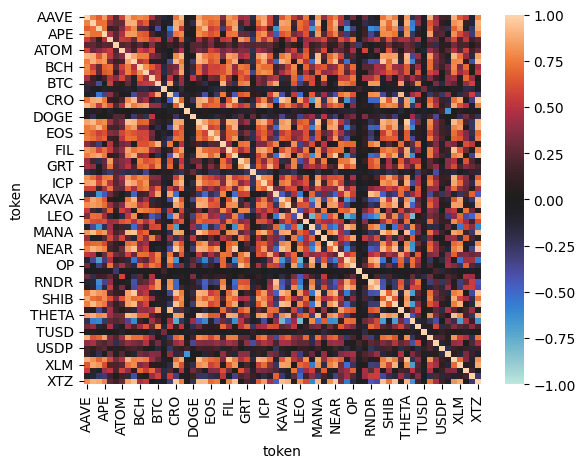

In [12]:
heatmap(corr_pearson)

Пирсон от Спирмена отличается не так сильно:

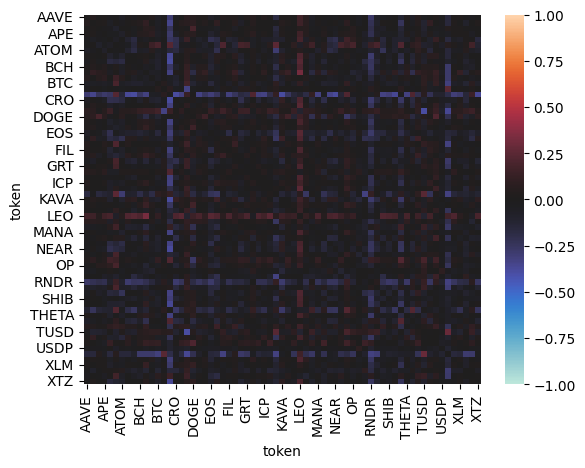

In [13]:
heatmap(corr_pearson - corr_spearman)

А вот Кендалл отличается от Пирсона и Спирмена существенно:

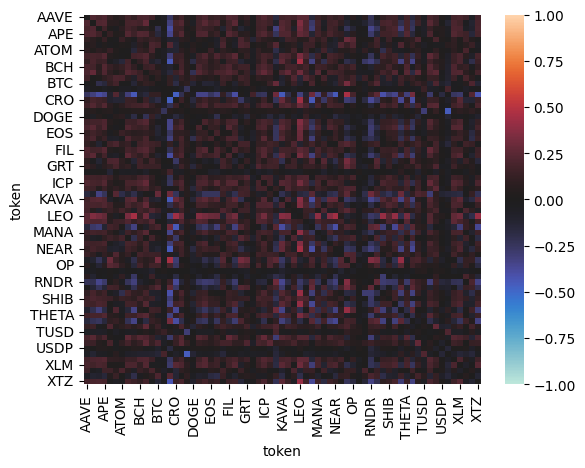

In [14]:
heatmap(corr_pearson - corr_kendall)

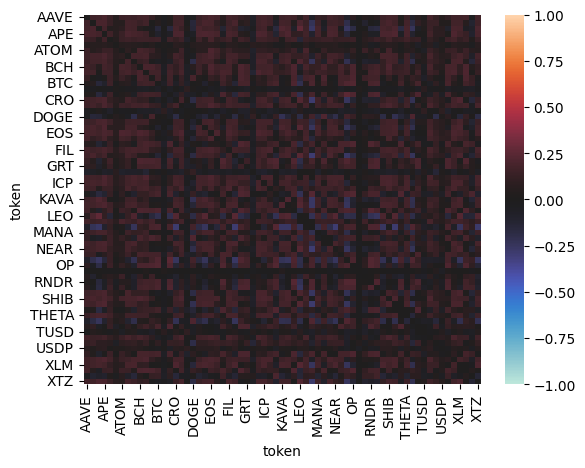

In [15]:
heatmap(corr_spearman - corr_kendall)

## Thresholded correlations

Значения корреляции ниже 0.8 по модулю -- не стоит воспринимать всерьёз. Поэтому можно сильно проредить матрицу, занулив все значения, меньшие по модулю, чем определённый порог (0.8, 0.9, 0.95). Смотрим, как это сработает на наших матрицах.

In [16]:
def threshold(df: pd.DataFrame, threshold: float = 0.8):
    def _threshold(corr: float):
        if abs(corr) > threshold:
            return 1# if corr > 0 else -1
        return 0
    return df * df.applymap(_threshold)

In [17]:
corr_pearson_t = threshold(corr_pearson)
corr_spearman_t = threshold(corr_spearman)
corr_kendall_t = threshold(corr_kendall)

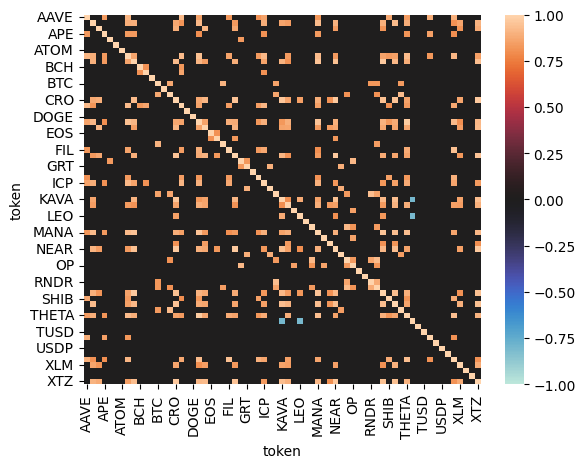

In [18]:
heatmap(corr_pearson_t)

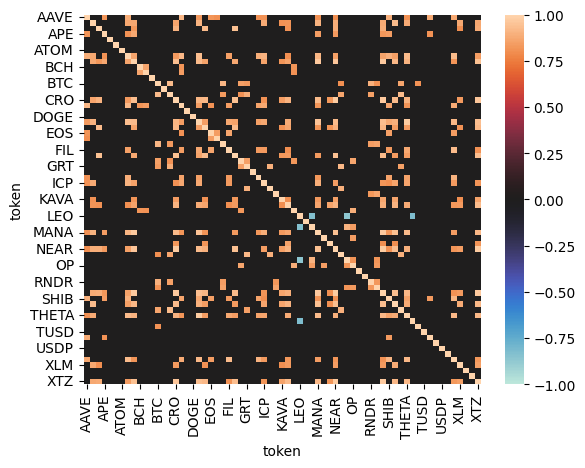

In [19]:
heatmap(corr_spearman_t)

Кендалл почти не находит корреляций в наших данных:

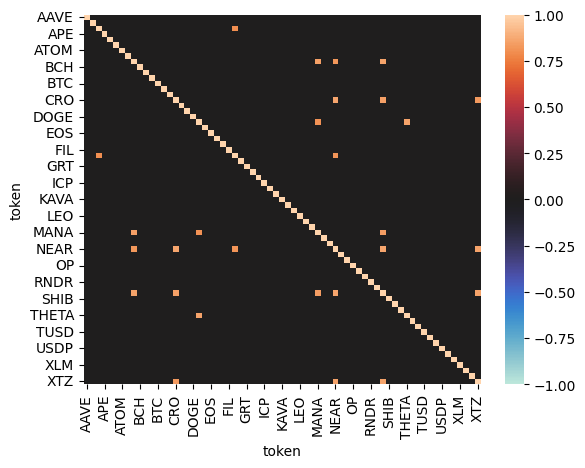

In [20]:
heatmap(corr_kendall_t)

Если оставить только большие корреляции, Пирсон начинает отличаться от Спирмена довольно сильно, причём в обе стороны: где-то Пирсон находит корреляцию, а Спирмен нет, а где-то наоборот. Это объяснимо: если корреляции различаются на 0.1, а значение близко к пороговому, то после "прополки" в одной матрице будет 1, а в другой 0.

Случаев, когда Пирсон видит положительную корреляцию, а Спирмен отрицательную -- нет. Это говорит о согласии методов (было бы подозрительно, если бы такие случаи были).

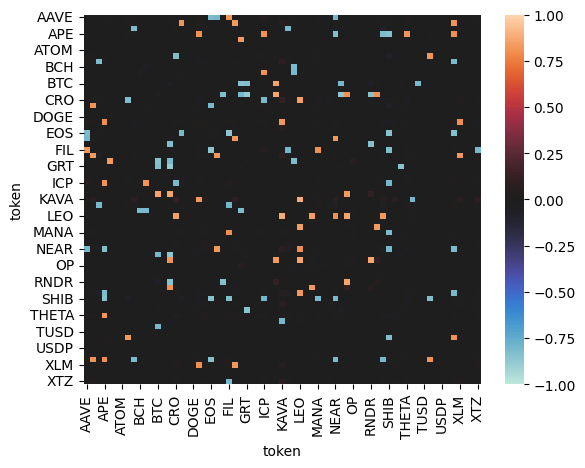

In [21]:
heatmap(corr_pearson_t - corr_spearman_t)

# [TODO] Correlations stability

Тут место для оценки стабильности.

# [TODO] Time-shifted correlations

Тут место для построения корреляций со сдвигом по времени.

Предлагаю взять один вид корреляции (например, корреляцию Спирмана), построить несколько матриц и посмотреть на разницу между ними. 

Можно переиспользовать код из предыдущих разделов.

# Choosing the distance

Для построения графа, остовного дерева и спектрограммы нам нужно расстояние между токенами: функция, которая (1) неотрицательна, (2) строго больше 0 для разных токенов, и равна 0 для одинаковых, (3) удовлетворяет неравенству треугольника: $d(x, y) \le d(x,z) + d(z,y)$ для любых токенов x, y, z и (4) симметрична: $d(x,y) = d(y,x)$.

Наши временные ряды токенов образуют 365-мерное векторное пространство, по одной координате на день.

С математической точки зрения, корреляция -- это скалярное произведение в векторном пространстве временных рядов котировок.

Известно, что по скалярному произведению можно построить расстояние, что мы и сделаем:

$$d(x,y) = \frac{1 - corr(x, y)}{2}$$

In [22]:
#values_to_analyse = values[market_caps.sort_values(ascending=False)[:20].index]
values_to_analyse = values
corr_to_analyze = values_to_analyse.corr('spearman')
distance = (1 - corr_to_analyze) / 2

# Graph on thresholded correlations

Построим и нарисуем граф связей между токенами:

* оставим только корреляции выше порога
* по корреляциям посчитаем расстояния

In [23]:
# Make a graph
links_ = (
    threshold(corr_spearman, 0.8)
    .stack()
    .to_frame('corr')
    )
links_.index.names = ['token_from', 'token_to']
links_.reset_index(inplace=True)
links_['_tokens'] = links_.apply(lambda row: sorted(row[['token_from', 'token_to']].values), axis=1)
links_.drop_duplicates(subset='_tokens', inplace=True)
del links_['_tokens']
links_['distance'] = (1 - links_['corr']) / 2
links = (
    links_
    .query('corr != 0')
    .query('token_from != token_to')
    .set_index(['token_from',  'token_to'])
)

token_graph = igraph.Graph()
vertices = distance.columns.values
token_graph.add_vertices(
    vertices, 
    attributes={'market_cap': market_caps[distance.columns].values}
)

for (token_from, token_to), row in links.iterrows():
    token_graph.add_edge(
        token_from, token_to, distance=row['distance'], corr=row['corr']
    )

# Plot a graph
#layout = token_graph.layout_fruchterman_reingold()
layout = token_graph.layout_kamada_kawai()
visual_style = {}
visual_style["vertex_size"] = (token_graph.vs['market_cap'] / np.max(token_graph.vs['market_cap'])) ** 0.5 * 100
visual_style["vertex_color"] = "#00000010"
visual_style["vertex_frame_color"] = 'white'
visual_style["vertex_label"] = token_graph.vs["name"]
visual_style["vertex_label_color"] = 'blue'
#visual_style["edge_label"] = [f'{np.round(corr, 1):.1f}' for corr in token_graph.es["corr"]]
visual_style["edge_width"] = [abs(corr)**4 * 8 for corr in token_graph.es["corr"]]
visual_style["edge_color"] = '#00000020'
visual_style["layout"] = layout
visual_style["bbox"] = (800, 1200)
visual_style["margin"] = 50

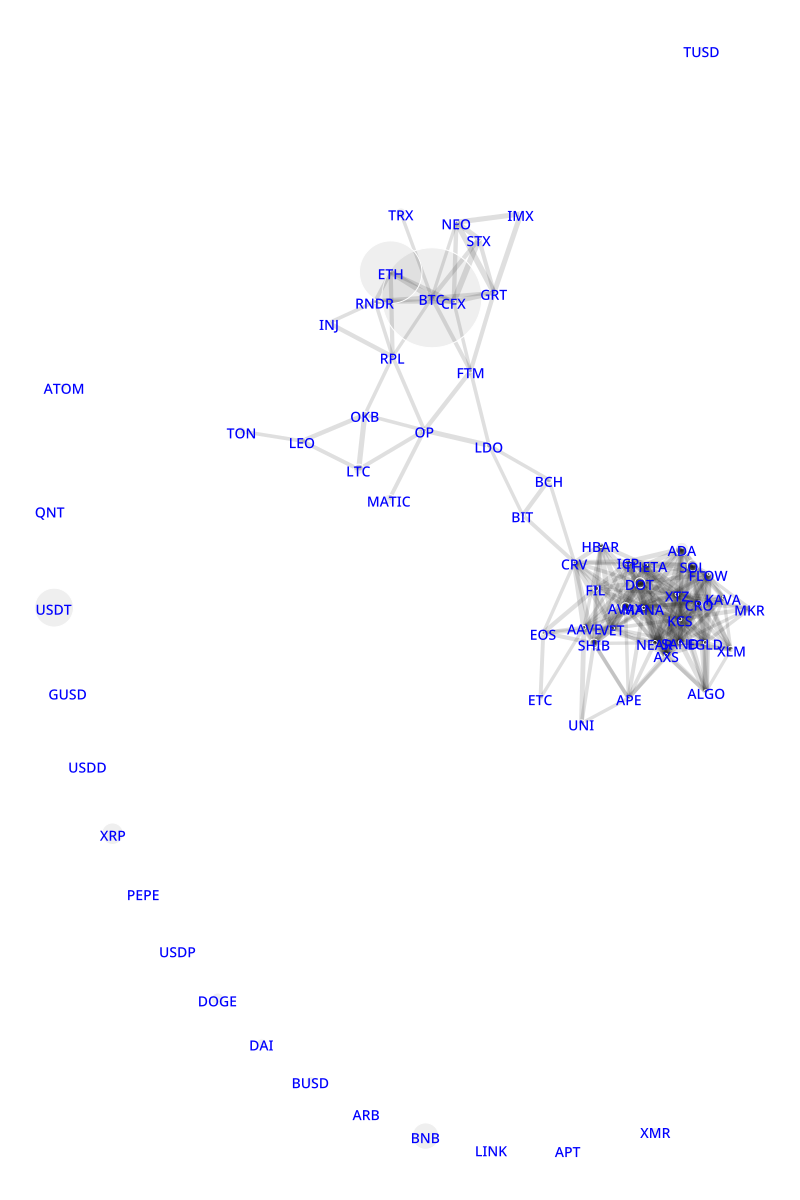

In [24]:
igraph.plot(token_graph, **visual_style)

Возьмём пару токенов, которые близки (или наоборот далеки) по графу, и посмотрим на их котировки. Проверим на здравый смысл: там, где корреляция высокая, ожидаем увидеть похожие графики, а где низкая - непохожие.

token
LEO    Axes(0.125,0.11;0.775x0.77)
TON    Axes(0.125,0.11;0.775x0.77)
Name: value, dtype: object

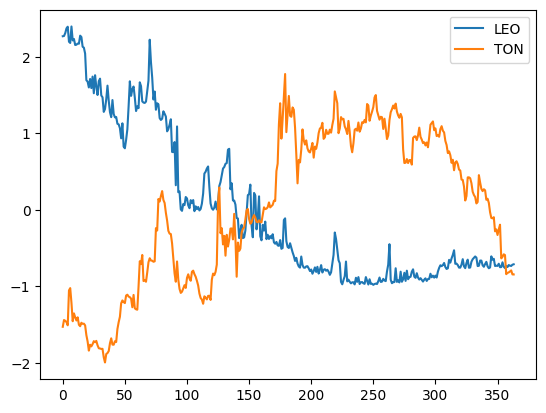

In [25]:
plot_ticks(ticks, ['TON', 'LEO'])

# Minimal spanning tree

По матрице расстояний построим минимальное остовное дерево. Красиво его нарисуем.

In [26]:
mst_links = (
    pd.DataFrame(
        minimum_spanning_tree(distance.values).todense(), 
        columns=distance.columns, index=distance.index)
    .stack()
    .to_frame('distance')
    .pipe(lambda df: df[df['distance'] != 0])
    .join(corr_spearman.stack().to_frame('corr'), how='left')
    .sort_values('distance')
)
mst_links.T

token          CRO      NEAR     THETA     NEAR      SAND      MANA            \
token         NEAR      SAND       DOT      XTZ       AXS      SAND       DOT   
distance  0.013710  0.014392  0.014406  0.01479  0.015651  0.018445  0.025210   
corr      0.972579  0.971216  0.971188  0.97042  0.968699  0.963109  0.949579   

token         FLOW      ALGO       SOL  ...     MATIC       QNT      KAVA  \
token          CRO      FLOW      MANA  ...      DOGE      ATOM      USDD   
distance  0.029879  0.030381  0.030654  ...  0.164029  0.191429  0.252322   
corr      0.940242  0.939238  0.938693  ...  0.671942  0.617143  0.495355   

token          ARB      GUSD      TUSD      BUSD      USDP       DAI     PEPE  
token         LINK      DOGE       DAI       DAI       APE      USDP     USDD  
distance  0.315464  0.326406  0.341824  0.347069  0.362376  0.367051  0.40845  
corr      0.369072  0.347188  0.316352  0.305862  0.275248  0.265898  0.18310  

[2 rows x 66 columns]

In [27]:
corr_spearman.loc['BNB', 'MATIC']

0.7891475896457216

In [28]:
mst = igraph.Graph()
vertices = distance.columns.values
mst.add_vertices(vertices, attributes={'market_cap': market_caps[distance.columns].values})

for (token_from, token_to), row in mst_links.iterrows():
    mst.add_edge(token_from, token_to, distance=row['distance'], corr=row['corr'])

layout = mst.layout_reingold_tilford(root=[mst.vs.find(name='BTC').index])

visual_style = {}
#visual_style["vertex_size"] = 40
#visual_style["vertex_size"] = np.log10(mst.vs['market_cap']) / np.log10(np.max(mst.vs['market_cap'])) * 40
visual_style["vertex_size"] = (mst.vs['market_cap'] / np.max(mst.vs['market_cap'])) ** 0.5 * 100
visual_style["vertex_color"] = "#00000010"
visual_style["vertex_frame_color"] = 'white'
visual_style["vertex_label"] = mst.vs["name"]
visual_style["vertex_label_color"] = 'blue'
visual_style["edge_label"] = [f'{np.round(corr, 1):.1f}' for corr in mst.es["corr"]]
visual_style["edge_width"] = [abs(corr)**4 * 12 for corr in mst.es["corr"]]
#visual_style["edge_color"] = [f'#000000{str(hex(int(96*abs(corr))))[-2:]}' for corr in mst.es["corr"]]
visual_style["edge_color"] = '#00000020'
visual_style["layout"] = layout
visual_style["bbox"] = (800, 1200)
visual_style["margin"] = 50

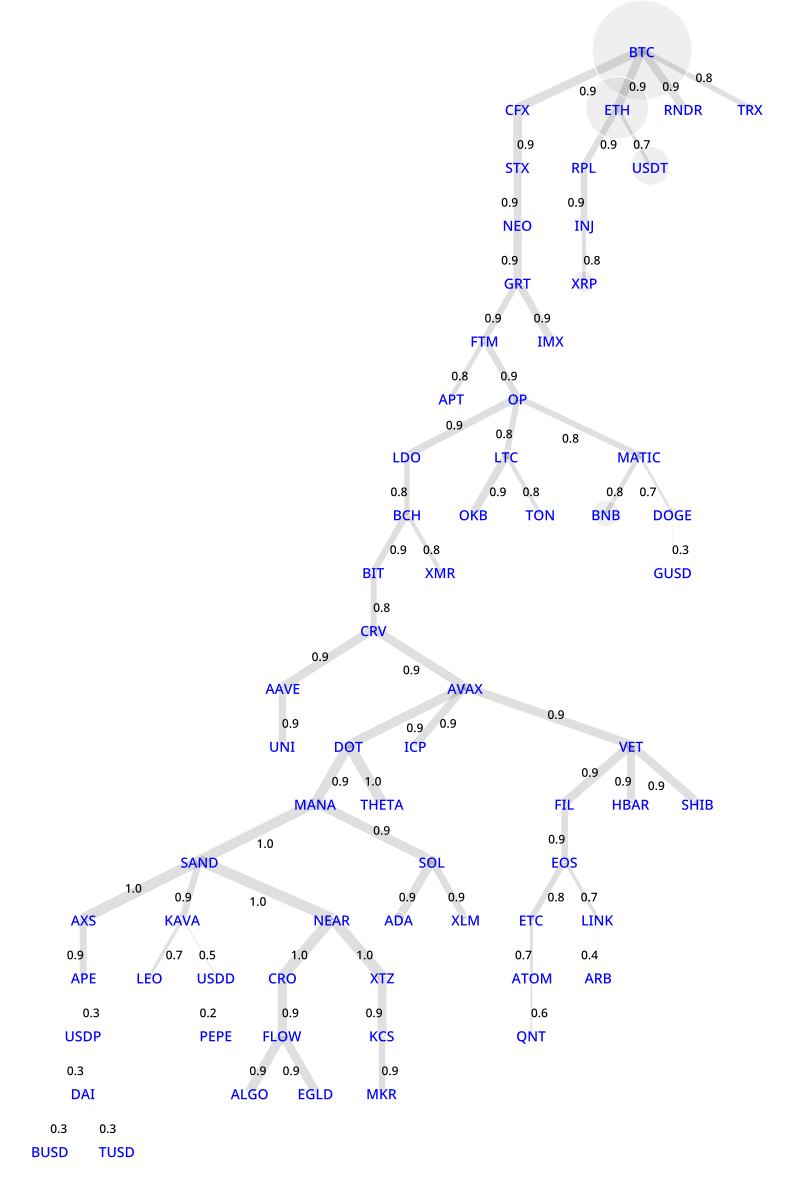

In [29]:
igraph.plot(mst, **visual_style)

Снова проверим несколько токенов, между которыми высокая корреляция (1.0 на дереве). Видим, что графики идут очень похоже.

token
AXS     Axes(0.125,0.11;0.775x0.77)
CRO     Axes(0.125,0.11;0.775x0.77)
MANA    Axes(0.125,0.11;0.775x0.77)
NEAR    Axes(0.125,0.11;0.775x0.77)
SAND    Axes(0.125,0.11;0.775x0.77)
XTZ     Axes(0.125,0.11;0.775x0.77)
Name: value, dtype: object

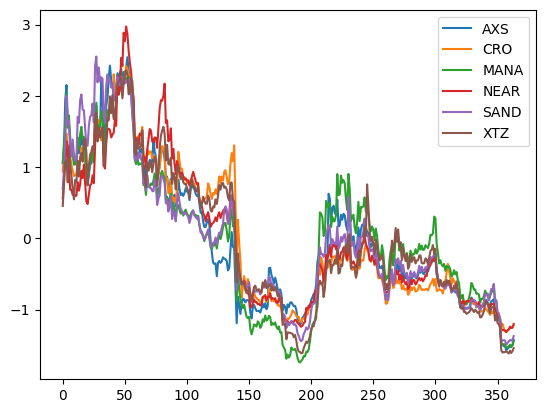

In [30]:
plot_ticks(ticks, ['MANA', 'SAND', 'AXS', 'NEAR', 'CRO', 'XTZ'])

# (*) Eigenvectors and spectrum

Попробуем посчитать спектр и собственные векторы матрицы расстояний. Согласно книжке Франтишека Сланины, из собственных векторов должны получиться подпространства совместно меняющихся токенов. Ожидаем, что эти кластера будут похожи на то, что получается по остовному дереву.

In [31]:
eigenvalues_, eigenvectors_ = eig(corr_spearman)

assert np.all(eigenvalues_.imag == 0)
eigenvalues = eigenvalues_.real

eigenvectors = pd.DataFrame(eigenvectors_, index=corr_to_analyze.index)

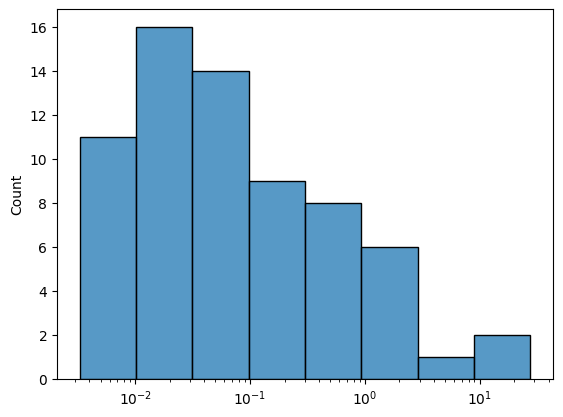

In [32]:
ax = sns.histplot(eigenvalues, log_scale=True)

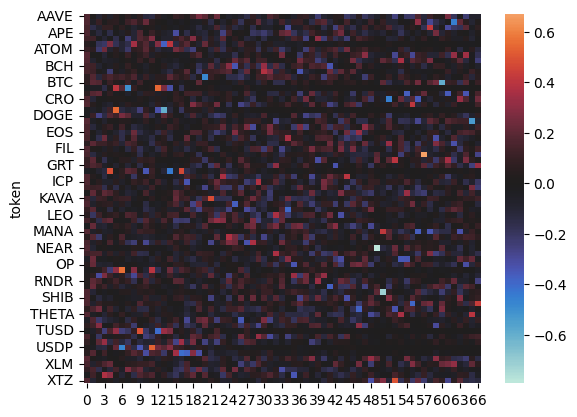

In [33]:
# Each eigenvector resides in its COLUMN.
ax = sns.heatmap(eigenvectors, center=0)

Считаем inverse participation ratio: склонность собственного вектора "оставаться в подпространстве".

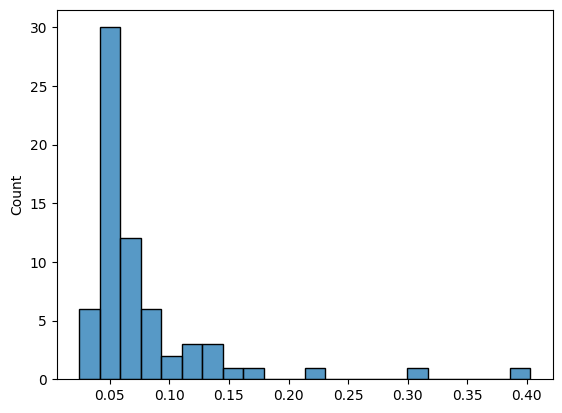

In [34]:
# inverse participation ratio: shows vectors distribution/concentration over dimensions
ipr = np.sum(eigenvectors ** 4, axis=0)

ax = sns.histplot(ipr)

[Text(0.5, 0, 'Eigenvalue, orders of 10'),
 Text(0, 0.5, 'Inverse participation ratio, orders of 10')]

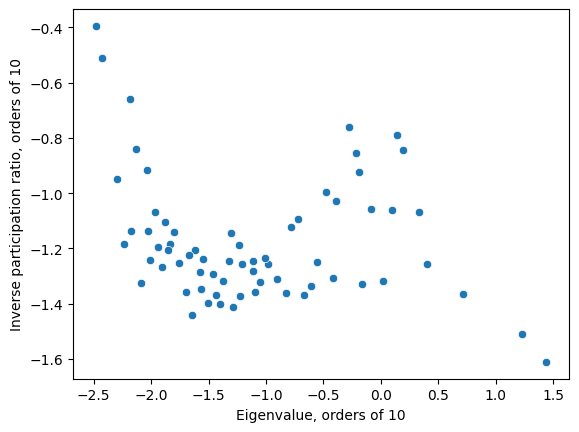

In [35]:
ax = sns.scatterplot(x=np.log10(eigenvalues), y=np.log10(ipr))
ax.set(xlabel="Eigenvalue, orders of 10", ylabel="Inverse participation ratio, orders of 10")

In [36]:
eigenvector_props = pd.DataFrame.from_dict({'eigenvalue': eigenvalues, 'ipr': ipr})
eigenvector_props.head(3)

eigenvalue       ipr
0   27.686360  0.024508
1   17.061094  0.031001
2    5.149517  0.043029

In [37]:
# Eigenvectors with which IPR to consider concentrated.
# The lower it, the more subspaces we fetch.
ipr_threshold = 0.15
# Tokens (coords) with how large value to take into concentration subspace.
# The lower it, the more tokens we take into the subspace.
ev_coord_threshold = 0.15

In [38]:
def l2_norm(arr):
    return np.sqrt(np.sum(arr ** 2))

def l1_norm(arr):
    return np.sum(np.abs(arr))

concentrated_eigenvectors = (
    eigenvectors
    [eigenvectors.columns[eigenvector_props['ipr'] > ipr_threshold]]
)

data = []
for col in concentrated_eigenvectors.columns:
    ev = concentrated_eigenvectors[col]
    subspace_mask = ev.abs() > ev_coord_threshold
    data.append([
        ev[subspace_mask].index.values,
        l2_norm(ev[subspace_mask]),
        l2_norm(ev[~subspace_mask]),
        l1_norm(ev[subspace_mask]),
        l1_norm(ev[~subspace_mask]),
    ])
conc_ev_props = pd.DataFrame(
    data, 
    columns=['tokens', 'l2 subspace', 'l2 other', 'l1 subspace', 'l1 other'],
).sort_values('l2 subspace', ascending=False)

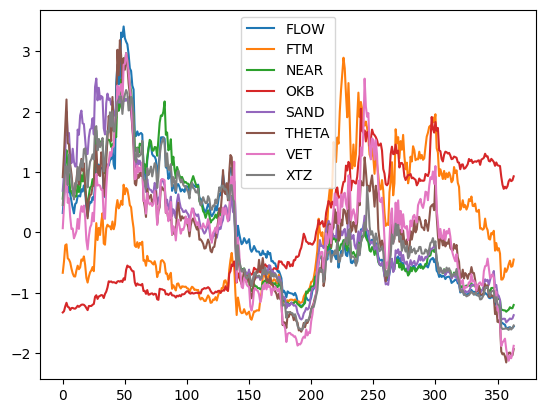

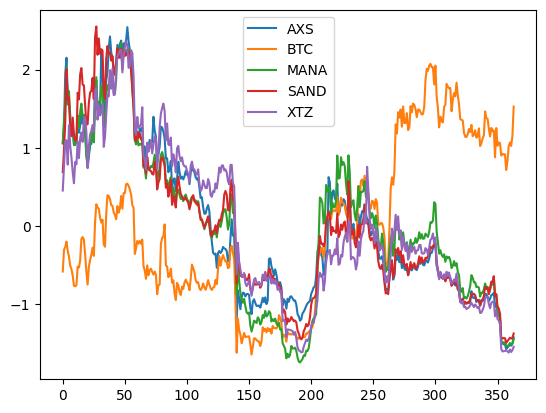

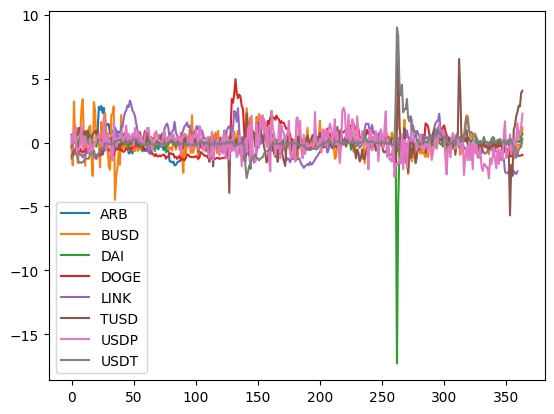

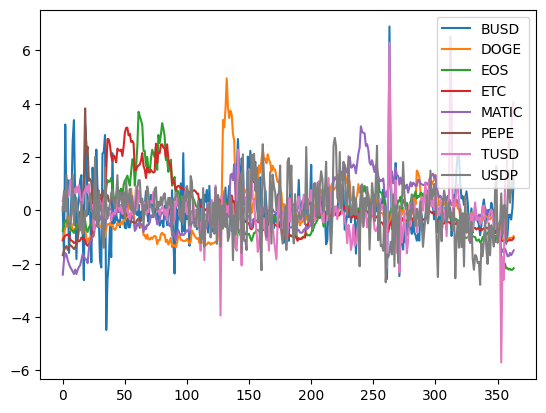

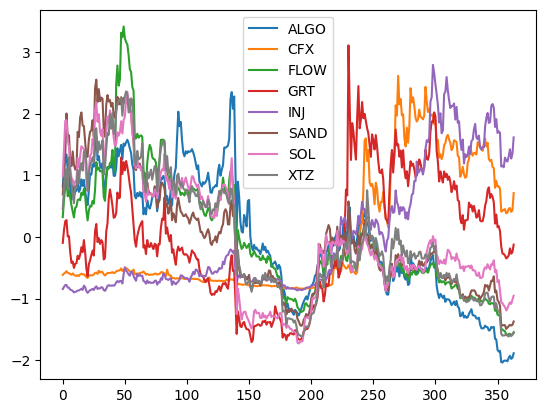

In [39]:
display(HTML(conc_ev_props.to_html()))
for _, row in conc_ev_props.iterrows():
    plt.figure()
    #conc_ev_ticks = ticks[ticks.token.isin(row['tokens'])]
    #conc_ev_ticks.groupby('token')['value'].plot(legend=True)
    plot_ticks(ticks, row['tokens'])

# (*) Trends

До этого мы смотрели на корреляции токенов (= структуру рынка), но не интересовались скоростью их роста/падения (= доходностью).

Глядя на графики капитализации, видим, что нет единого годового тренда, но есть микро-тренды длиной в несколько недель-месяцев, и один тренд сменяет другой стремительно (график "ломается").

Поэтому линия тренда токена будет кусочно-линейной. Библиотека facebook prophet позволяет находить кусочно-линейные тренды. Посмотрим, что она нам расскажет.

In [40]:
def _get_trends(
    ticks: pd.DataFrame, 
    token: str,
    metric: str = 'value'
):
    assert {metric, 'token', 'dttm'} <= set(ticks.columns)
    ticks_for_one = (
        ticks
        .query(f'token == "{token}"')
        [['dttm', metric]]
        .copy()
        .rename(columns={'dttm': 'ds', metric: 'y'})
        )
    model = Prophet(changepoint_prior_scale=0.5)
    model.fit(ticks_for_one)
    return model    

def plot_trends(
    ticks: pd.DataFrame, 
    token: str,
    metric: str = 'value',
    periods: int = 91,
):
    model = _get_trends(ticks, token, metric)
    prediction = model.predict(model.make_future_dataframe(periods=periods))
    fig = model.plot(prediction)
    add_changepoints_to_plot(fig.gca(), model, prediction)
    model.plot_components(prediction);
    return model, prediction

18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing


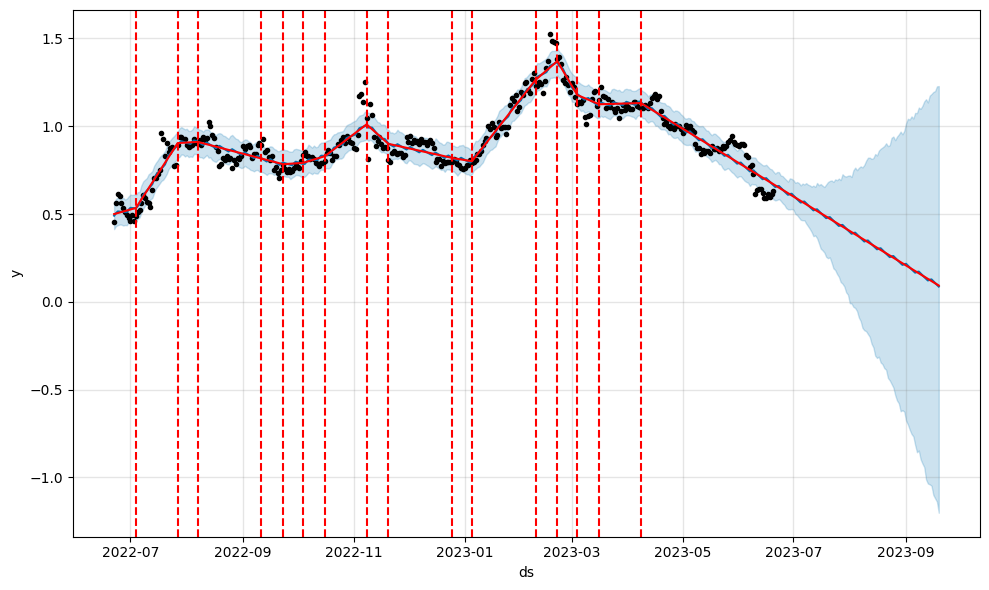

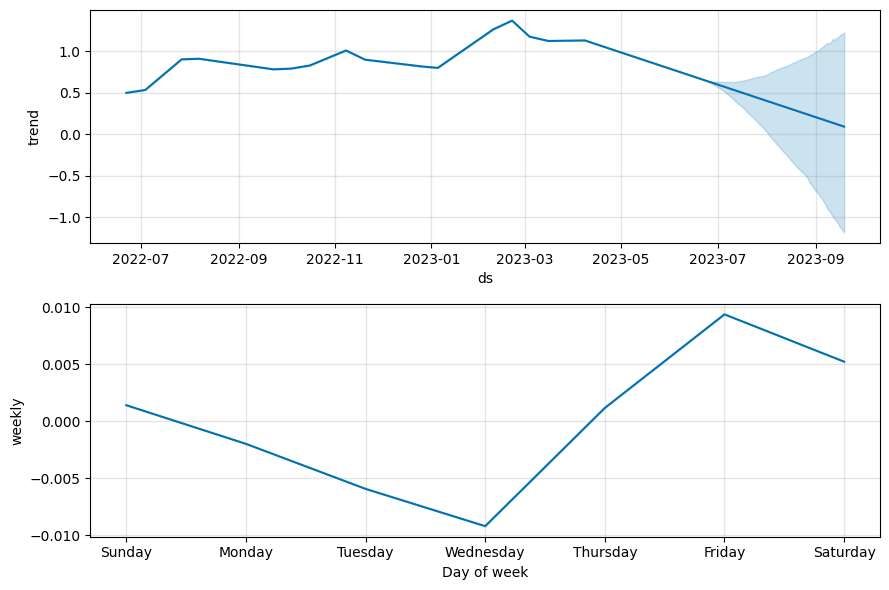

In [41]:
model, prediction = plot_trends(ticks, 'MATIC', 'close')

Тренды по цене закрытия:

* Prophet нашел недельную сезонность.
* Выделил сегменты линии тренда. Некоторые сегменты выглядят близкими (их хочется объединить).
* Сегментов не очень много, длительность кусков сопоставима (нет супер-длинных и супер-коротких сегментов).

Вытащим из prophet сырые данные о смене направлений тренда:

In [42]:
slopes = list(model.params['k'][0]) + list(model.params['delta'][0])

pieces = pd.DataFrame.from_dict({
    'dt_from': [model.history.ds.min()] + list(model.changepoints),
    'dt_to': list(model.changepoints) + [model.history.ds.max()],
    'k': np.cumsum(slopes),
    'k_delta': list(model.params['delta'][0]) + [None]
})

pieces.query('abs(k_delta) > 0.1')

dt_from      dt_to         k   k_delta
0  2022-06-22 2022-07-04  0.693031  3.126670
2  2022-07-15 2022-07-27  3.819699 -3.670140
3  2022-07-27 2022-08-07  0.149559 -0.788883
7  2022-09-11 2022-09-23 -0.660838  0.832967
8  2022-09-23 2022-10-04  0.172129  0.577386
9  2022-10-04 2022-10-16  0.749515  1.127620
11 2022-10-28 2022-11-08  1.877134 -4.078010
12 2022-11-08 2022-11-20 -2.200876  1.655250
15 2022-12-13 2022-12-25 -0.549899  0.149423
16 2022-12-25 2023-01-05 -0.400476  3.548810
19 2023-01-28 2023-02-09  3.145755 -1.025270
20 2023-02-09 2023-02-21  2.120485 -6.295200
21 2023-02-21 2023-03-04 -4.174715  3.132050
22 2023-03-04 2023-03-16 -1.042665  1.113840
24 2023-03-27 2023-04-08  0.071231 -1.578570

Посмотрим, насколько похоже получится, если вместо цены закрытыия взять нормированное значение:

18:03:47 - cmdstanpy - INFO - Chain [1] start processing
18:03:47 - cmdstanpy - INFO - Chain [1] done processing


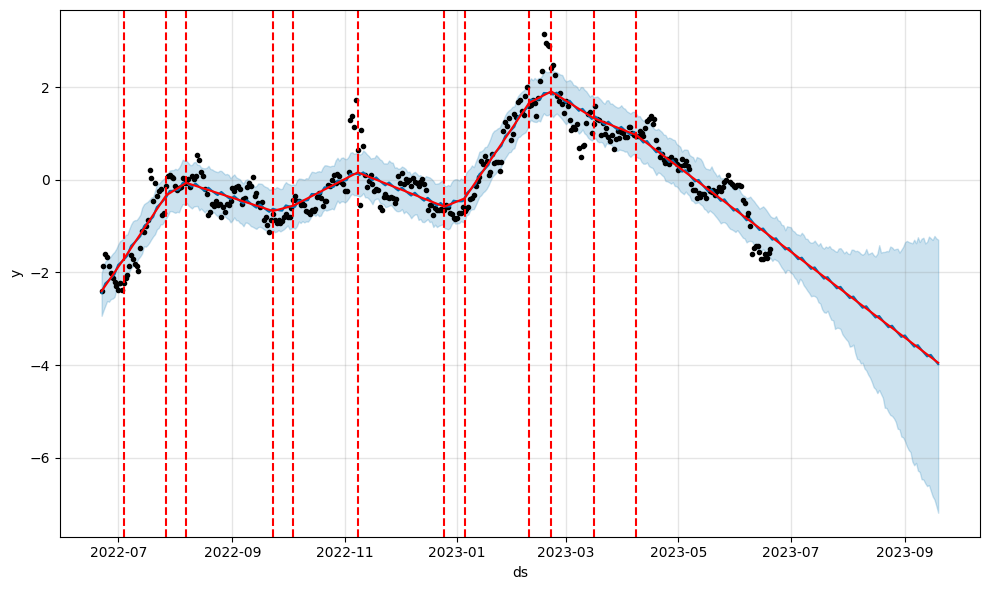

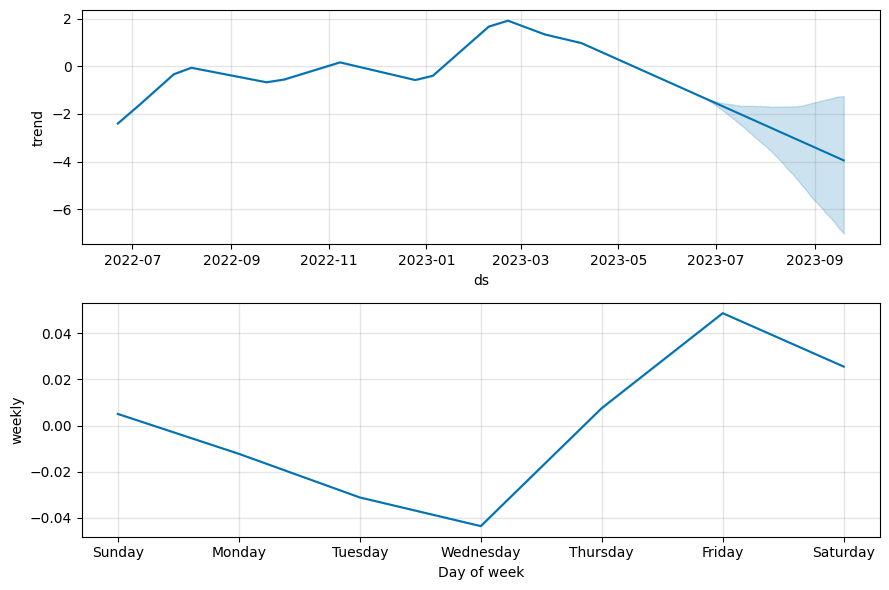

In [43]:
model, prediction = plot_trends(ticks, 'MATIC', 'value');

# [TODO] Iterative portfolio picker

Тут когда-нибудь появится функция, которая оценивает лежащие в портфеле токены и помогает оценить качество портфеля:

* диверсификацию
* доходность
* ещё что-нибудь полезное

In [44]:
remove_tokens_threshold = 0.80

portfolio = ['TRX', 'BNB', 'FTM', 'MATIC']

for token in portfolio:
    s = corr_to_analyze[token]
    print(s[s.abs() > remove_tokens_threshold])

token
BTC    0.810669
TRX    1.000000
Name: TRX, dtype: float64
token
BNB    1.0
Name: BNB, dtype: float64
token
BTC    0.845583
CFX    0.811301
FTM    1.000000
GRT    0.851534
LDO    0.823413
OP     0.862813
Name: FTM, dtype: float64
token
MATIC    1.000000
OP       0.838638
Name: MATIC, dtype: float64


In [45]:
portfolio

['TRX', 'BNB', 'FTM', 'MATIC']